In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize_scalar
from numba import njit, prange, float64
from joblib import Parallel, delayed
import multiprocessing
from matplotlib import cm

In [4]:

def visualize_results_old(V, optimal_p, x_grid, N):
    """
    可视化最优策略P与状态X的差异随时间的变化
    
    参数:
    V - 价值函数矩阵 (N+1, num_grid_points)
    optimal_p - 最优策略矩阵 (N, num_grid_points)
    x_grid - 状态网格 (num_grid_points,)
    N - 时间步数
    """
    # 时间点t的数组，从0到(N-1)/N，共N个点
    t = np.arange(N) / N
    
    # 计算每个时间点的平均差异 (P - X)
    avg_diff = np.mean(optimal_p - x_grid, axis=1)
    
    # 找到x=0附近的索引
    x_target = 0.0
    j = np.argmin(np.abs(x_grid - x_target))
    diff_at_0 = optimal_p[:, j] - x_grid[j]
    
    # 创建图表
    plt.figure(figsize=(10, 6))
    
    # 绘制平均差异曲线
    plt.plot(t, avg_diff, 'b-', marker='o', label='Average Difference (P - X)')
    
    # 绘制x=0处的差异曲线
    plt.plot(t, diff_at_0, 'r--', marker='x', label=f'Difference at X={x_target:.1f}')
    
    # 设置图表属性
    plt.xlabel('Time (t)')
    plt.ylabel('Difference')
    plt.title('Optimal Policy P vs. State X Difference over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def visualize_results(V, optimal_p, x_grid, N, S=0):
    """
    增强的可视化函数：同时展示策略差异和价值函数特性
    
    参数:
    V - 价值函数矩阵 (N+1, num_grid_points)
    optimal_p - 最优策略矩阵 (N, num_grid_points)
    x_grid - 状态网格 (num_grid_points,)
    N - 时间步数
    S - 强制平仓惩罚值（用于标注）
    """
    plt.figure(figsize=(15, 12))
    
    # ---------------------------
    # 子图1: 策略差异 (P - X) 随时间变化
    # ---------------------------
    plt.subplot(2, 2, 1)
    
    # 时间点数组（从t=0到t=(N-1)/N）
    t_policy = np.arange(N) / N
    
    # 计算每个时间点的平均差异 (P - X)
    avg_diff = np.mean(optimal_p - x_grid, axis=1)
    
    # 找到x=0附近的索引
    j_zero = np.argmin(np.abs(x_grid - 0.0))
    diff_at_zero = optimal_p[:, j_zero] - x_grid[j_zero]
    
    # 绘制曲线
    plt.plot(t_policy, avg_diff, 'b-', marker='o', markersize=4, label='Average (P - X)')
    plt.plot(t_policy, diff_at_zero, 'r--', marker='x', markersize=4, label=f'At X=0')
    
    # 标注关键点
    plt.scatter(t_policy[0], avg_diff[0], color='green', zorder=5, label='t=0')
    plt.scatter(t_policy[-1], avg_diff[-1], color='purple', zorder=5, label='t=1-Δt')
    
    plt.xlabel('Time (t)')
    plt.ylabel('P - X')
    plt.title(f'Optimal Policy Difference (S={S})')
    plt.legend()
    plt.grid(True)

    # ---------------------------
    # 子图2: 价值函数V(t, x)在不同时间点的曲线
    # ---------------------------
    plt.subplot(2, 2, 2)
    
    # 选择关键时间点（初始、中间、终止前一步）
    selected_t_indices = [0, N//2, N-1]
    colors = ['blue', 'green', 'red']
    labels = ['t=0', f't={selected_t_indices[1]/N:.2f}', 't=1-Δt']
    
    for idx, t_idx in enumerate(selected_t_indices):
        plt.plot(x_grid, V[t_idx], 
                 color=colors[idx], 
                 linestyle='--' if idx == 1 else '-',
                 label=labels[idx])
    
    # 标注理论终端条件（当S=0时V(t=1, x)=x）
    if S == 0:
        plt.plot(x_grid, x_grid, 'k:', linewidth=1, label='V(t=1, x)=x (Theory)')
    
    plt.xlabel('State X')
    plt.ylabel('Value V(t, x)')
    plt.title('Value Function at Selected Time Points')
    plt.legend()
    plt.grid(True)

    # ---------------------------
    # 子图3: 价值函数在X=0处随时间的变化
    # ---------------------------
    plt.subplot(2, 2, 3)
    
    # 时间点数组（从t=0到t=1）
    t_value = np.linspace(0, 1, N+1)
    
    # 提取X=0处的价值（需要插值）
    V_at_zero = np.array([np.interp(0.0, x_grid, V[i]) for i in range(N+1)])
    
    plt.plot(t_value, V_at_zero, 'm-', marker='o', markersize=4)
    plt.xlabel('Time (t)')
    plt.ylabel('V(t, X=0)')
    plt.title('Value Function at X=0 over Time')
    plt.grid(True)

    # ---------------------------
    # 子图4: 价值函数的3D曲面图（时间和状态）
    # ---------------------------
    ax = plt.subplot(2, 2, 4, projection='3d')
    
    T, X = np.meshgrid(np.linspace(0, 1, N+1), x_grid)
    V_matrix = np.array(V).T  # 转置为 (x_grid, time) 形状
    
    surf = ax.plot_surface(T, X, V_matrix, cmap=cm.coolwarm, linewidth=0, antialiased=True)
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('State X')
    ax.set_zlabel('Value V(t, x)')
    ax.set_title('3D View of Value Function')
    plt.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    # ---------------------------
    # 全局调整
    # ---------------------------
    plt.tight_layout()
    plt.show()

In [8]:
@njit(cache=True)
def normal_cdf(x):
    """
    更高精度的标准正态分布累积分布函数 (CDF) 近似。
    不依赖任何外部库的 erf 或特殊函数。
    """
    # 若需要可在极值处截断，避免极端情况下的浮点下溢/上溢。
    # 比如 if x > 8.0: return 1.0; if x < -8.0: return 0.0

    # 符号，用于把所有计算转化为 x >= 0 的情况
    sign = 1 if x >= 0 else -1
    x = abs(x)

    # 常数项
    # 这些系数是较为经典的一组，精度通常可达到 1e-7 左右。
    p = 0.2316419
    b1 = 0.319381530
    b2 = -0.356563782
    b3 = 1.781477937
    b4 = -1.821255978
    b5 = 1.330274429

    # 1/sqrt(2π)
    c = 0.3989422804014327

    # 多项式部分
    t = 1.0 / (1.0 + p * x)
    # φ(x) = c * exp(-x^2/2)
    pdf = c * np.exp(-0.5 * x * x)
    # 多项式近似项
    poly = (b1 * t + b2 * t**2 + b3 * t**3 + b4 * t**4 + b5 * t**5)
    # 对于 x >= 0 的近似 CDF
    y = 1.0 - pdf * poly

    # 若原 x < 0，则利用对称性进行修正
    return y if sign == 1 else 1.0 - y

In [ ]:
@njit(cache=True)
def normal_cdf(x):
    """Numba加速的标准正态分布累积函数，无需使用 scipy 或 math.erf"""
    # Abramowitz & Stegun 公式参数
    a1, a2, a3, a4, a5 = 0.254829592, -0.284496736, 1.421413741, -1.453152027, 1.061405429
    p = 0.3275911

    # 计算符号
    sign = 1.0 if x >= 0 else -1.0
    x = abs(x) / np.sqrt(2.0)

    # 近似 erf 的公式
    t = 1.0 / (1.0 + p * x)
    erf_approx = 1.0 - (((((a5 * t + a4) * t) + a3) * t + a2) * t + a1) * t * np.exp(-x * x)

    # 标准正态分布的 CDF
    cdf = 0.5 * (1.0 + sign * erf_approx)
    return cdf

@njit(cache=True)
def normal_pdf(x):
    """Numba加速的标准正态分布密度函数"""
    return np.exp(-0.5 * x**2) / np.sqrt(2.0 * np.pi)


@njit(cache=True)
def calculate_expected_continuation(x, p, x_grid, V_next, std_dev):
    """计算给定p和x时的期望继续价值"""
    # 用矩形法则进行数值积分
    dx = (x_grid[-1] - x_grid[0]) / (len(x_grid) - 1)
    integral = 0.0
    
    for y_idx in range(len(x_grid)):
        y = x_grid[y_idx]
        if y >= p:
            break
        
        density = normal_pdf((y - x) / std_dev) / std_dev
        integral += V_next[y_idx] * density * dx
    
    return integral

@njit(cache=True)
def objective_function(p, x, x_grid, V_next, std_dev, x_min):
    """计算单个p值的目标函数"""
    # 确保 p >= x
    p_constrained = max(p, x)
    
    # 计算P(X_{t_{i+1}} >= p | X_{t_i} = x)
    prob_stop = 1 - normal_cdf((p_constrained - x) / std_dev)
    
    # 若停止的预期收益
    reward_if_stop = p_constrained * prob_stop
    
    # 若继续的预期收益
    expected_continuation = calculate_expected_continuation(x, p_constrained, x_grid, V_next, std_dev)
    
    # 总预期收益
    return reward_if_stop + expected_continuation



@njit(parallel=True)
def solve_optimal_stopping_numba(N, sigma, S, x_min, x_max, num_grid_points):
    """
    纯Numba加速版本的动态规划求解函数
    使用并行计算处理每个时间步中的所有状态点
    """
    # 创建状态空间网格
    x_grid = np.linspace(x_min, x_max, num_grid_points)
    
    # 初始化价值函数和最优控制
    V = np.zeros((N + 1, num_grid_points))
    optimal_p = np.zeros((N, num_grid_points))
    number_of_p = 800
    # 终端条件: V(t_N, x) = x - S
    V[N, :] = x_grid - S
    
    # 向后归纳
    for i in range(N - 1, -1, -1):
        dt = 1/N
        std_dev = sigma * np.sqrt(dt)
        
        # 获取下一时间步的价值函数
        V_next = V[i+1, :]
        
        # 并行处理每个状态点
        for j in prange(num_grid_points):
            x = x_grid[j]
            
            # 网格搜索查找最优p
            best_p = x
            best_value = -np.inf
            
            # 搜索可能的p值
            p_step = (x_max - x) / number_of_p
            for k in range(number_of_p+1):  # 50个网格点
                p = x + k * p_step
                if p > x_max:
                    break
                    
                value = objective_function(p, x, x_grid, V_next, std_dev, x_min)
                if value > best_value:
                    best_value = value
                    best_p = p
                    
            optimal_p[i, j] = best_p
            V[i, j] = best_value
    
    return V, optimal_p, x_grid


In [37]:
"""主函数"""
# 参数设置
N = 200     # 时间步数
sigma = 1 # 波动率
S =   0.5 # 终端惩罚

# 状态空间网格
x_min = -10
x_max = 10
num_grid_points = 1000

# 运行性能测试
import time

print("计算中，请稍候...")


# 预热Numba JIT编译器
_ = solve_optimal_stopping_numba(5, sigma, S, x_min, x_max, 20)

# 测试纯Numba版本
start_time = time.time()
V_numba, optimal_p_numba, x_grid = solve_optimal_stopping_numba(
    N, sigma, S, x_min, x_max, num_grid_points
)
numba_time = time.time() - start_time
print(f"Numba版本计算时间: {numba_time:.3f} 秒")



计算中，请稍候...
Numba版本计算时间: 36.128 秒


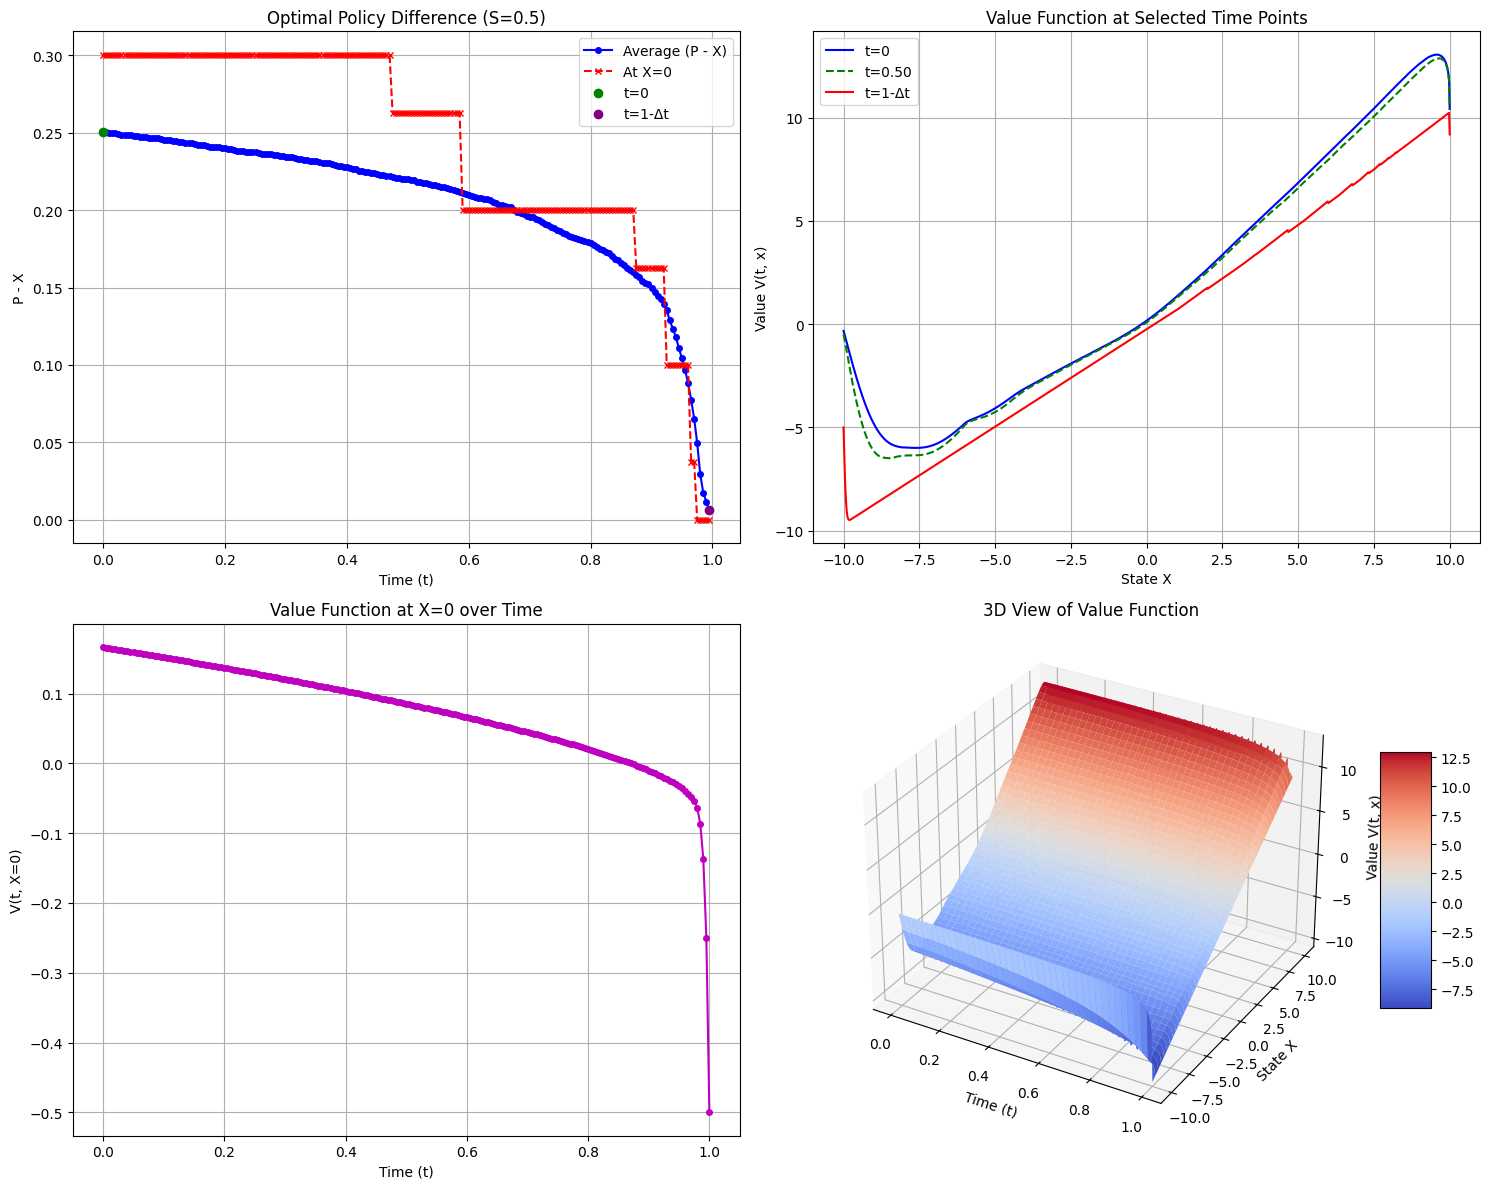

In [38]:
# 可视化结果 (使用Numba版本的结果)
visualize_results(V_numba, optimal_p_numba, x_grid, N,S=S)

In [131]:
def visualize_policy_diff_vs_S_and_time(S_list, sigma=0.2, N=100, x_min=-2.0, x_max=2.0, num_grid_points=200):
    """
    可视化不同S值下最优策略差异 (P - X) 随时间t的变化
    
    参数:
    S_list - 需要对比的S值列表，如 [0, 0.5, 1.0]
    sigma - 波动率
    N - 时间步数
    x_min, x_max - 状态网格范围
    num_grid_points - 状态网格点数
    """
    plt.figure(figsize=(12, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(S_list)))  # 颜色映射
    time_points = np.arange(N) / N  # 时间点t从0到 (N-1)/N
    
    for s_idx, S in enumerate(S_list):
        # 求解最优策略
        _, optimal_p, x_grid = solve_optimal_stopping_numba(
            N=N, sigma=sigma, S=S, x_min=x_min, x_max=x_max, num_grid_points=num_grid_points
        )
        
        # 计算每个时间步的差异指标
        avg_diff = np.mean(optimal_p - x_grid, axis=1)       # 平均差异
        zero_idx = np.argmin(np.abs(x_grid - 0.0))          # X=0附近的索引
        diff_at_zero = optimal_p[:, zero_idx] - x_grid[zero_idx]  # X=0处的差异
        
        # 绘制平均差异曲线
        plt.plot(time_points, avg_diff, 
                 color=colors[s_idx], 
                 linestyle='-',
                 linewidth=2,
                 label=f'S={S} (Avg)')
        
        # 绘制X=0处的差异曲线（虚线）
        plt.plot(time_points, diff_at_zero, 
                 color=colors[s_idx], 
                 linestyle='--',
                 linewidth=1.5,
                 alpha=0.7,
                 label=f'S={S} (X=0)')
    
    # 标注关键区域
    plt.axhline(0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    plt.axvline(1.0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='t=1 (Terminal)')
    
    # 设置图表属性
    plt.xlabel('Time (t)', fontsize=12)
    plt.ylabel('Optimal Policy Difference (P - X)', fontsize=12)
    plt.title(f'Policy Difference vs. Time and S (σ={sigma}, N={N})', fontsize=14)
    plt.legend(ncol=2, fontsize=10, loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 1.0)
    plt.tight_layout()
    plt.show()

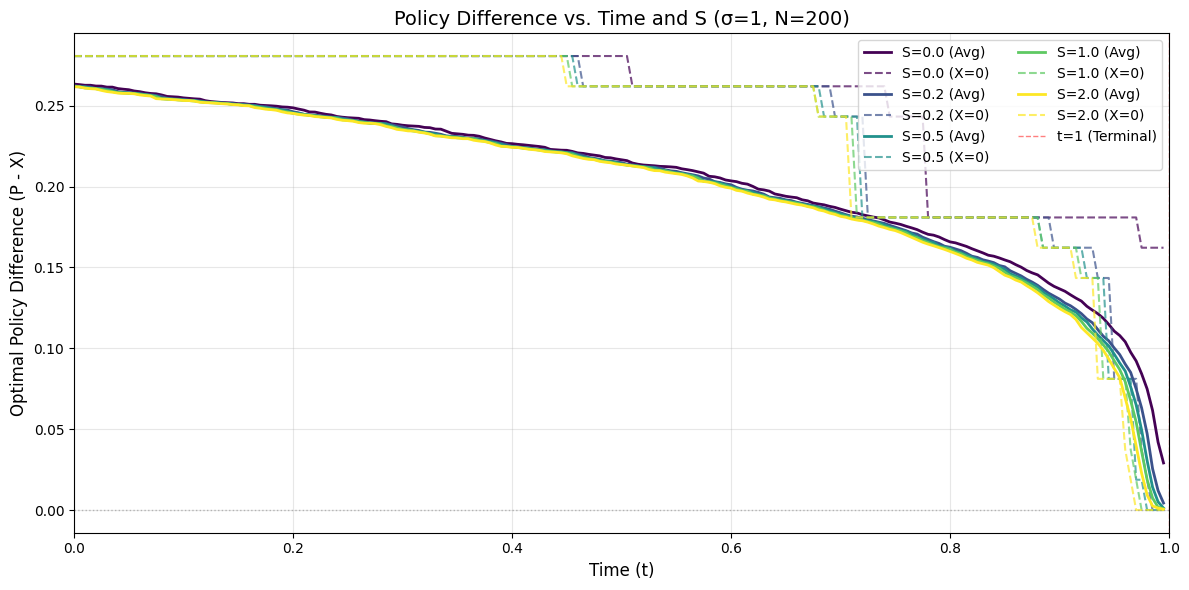

In [132]:
visualize_policy_diff_vs_S_and_time([0.,0.2,0.5,1.0,2.0], sigma=1, N=200, x_min=-5, x_max=5, num_grid_points=500)   

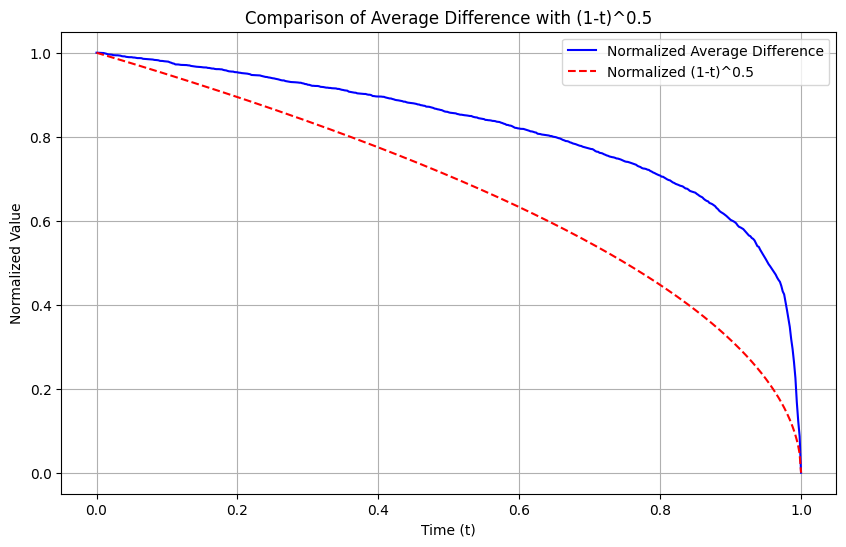

In [34]:
import numpy as np

import matplotlib.pyplot as plt

# 计算每个时间步的平均差异
avg_diff = np.append((optimal_p_numba - x_grid).mean(axis=1),0)

# 创建时间网格 t
t = np.arange(N+1) / N

# 计算 (1-t)^0.5
theoretical = np.sqrt(1 - t)

# 归一化以便比较
avg_diff_normalized = avg_diff / avg_diff[0]
theoretical_normalized = theoretical / theoretical[0]

# 绘图比较
plt.figure(figsize=(10, 6))
plt.plot(t, avg_diff_normalized, 'b-', label='Normalized Average Difference')
plt.plot(t, theoretical_normalized, 'r--', label='Normalized (1-t)^0.5')
plt.xlabel('Time (t)')
plt.ylabel('Normalized Value')
plt.title('Comparison of Average Difference with (1-t)^0.5')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
@njit(cache=True)
def theoretical_optimal_price_ratio(t):
    """
    计算连续时间下S=0时的理论最优价格比例
    对于S=0的情况，理论上t接近1时，最优价格应该接近当前价格
    """
    # 当S=0时，理论上最优比例为1（即p_t应该等于x_t）
    return 1.0

def verify_optimal_solution_S0(N_values, sigma=0.2, x_min=0.5, x_max=1.5, num_grid_points=1000):
    """
    验证当S=0时，随着N增大，最优解是否接近理论解
    
    参数:
    - N_values: 时间步数列表
    - sigma: 波动率
    - x_min, x_max: 状态空间边界
    - num_grid_points: 状态空间网格点数
    """
    # 存储结果
    results = []
    
    # 我们关注的几个时间点
    time_points = [0.0, 0.25, 0.5, 0.75, 0.99]  # 注意使用0.99而不是1.0，因为在t=1时有特殊边界条件
    
    for N in N_values:
        print(f"正在求解 N={N} 的情况...")
        start_time = time.time()
        
        # 求解S=0的情况
        S = 0.0
        V, optimal_p, x_grid = solve_optimal_stopping_numba(N, sigma, S, x_min, x_max, num_grid_points)
        
        # 计算每个时间点的平均价格比例 (p_t/x_t)
        ratios = {}
        for t_idx, t in enumerate(time_points):
            i = int(t * N)  # 对应的时间步索引
            if i >= N:
                i = N-1  # 确保不超出范围
                
            # 计算每个状态点的价格比例
            price_ratios = optimal_p[i] / x_grid
            
            # 存储平均比例
            ratios[t] = np.mean(price_ratios)
        
        elapsed = time.time() - start_time
        print(f"N={N} 求解完成，耗时: {elapsed:.2f}秒")
        
        results.append((N, ratios))
    
    # 可视化结果
    plt.figure(figsize=(10, 6))
    
    for t in time_points:
        N_list = [r[0] for r in results]
        ratio_list = [r[1][t] for r in results]
        plt.plot(N_list, ratio_list, 'o-', label=f't={t}')
        
        # 添加理论值的水平线
        theory_ratio = theoretical_optimal_price_ratio(t)
        plt.axhline(y=theory_ratio, linestyle='--', alpha=0.5, 
                    color=plt.gca().lines[-1].get_color(), 
                    label=f't={t} (理论值)')
    
    plt.xscale('log')
    plt.xlabel('时间步数 N (对数尺度)')
    plt.ylabel('最优价格比例 (p_t/x_t)')
    plt.title('S=0时，最优价格比例随N变化的收敛性')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    
    return results